In [1]:
# Imports 

import sys
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import dassl
import copy
from torchvision import transforms
import torch
import csv
import random
import numpy as np
from munch import DefaultMunch 
from PIL import Image 
from tqdm import tqdm

sys.path.append(r'/home/afroehli/coding/OOD-X-Benchmarks')
from datasets import imagenet_x as i_x, imagenet_r_x as r_x, imagenet_c_x as c_x, imagenet_v2_x as v2_x

sys.path.append(r'/home/afroehli/coding/util_scripts')
from utils_dataloading.dassl_datum_mod import DatumWithWnid 
from utils_dataloading.imagenet_tree import ImagenetSemanticInfo, ImagenetSemanticSubtree

In [2]:
# Create dataset instances if necessary 

cfg = dict()
cfg["DATASET"] = dict()
cfg["DATASET"]["ROOT"] = r"/home/afroehli/coding/OOD-X-Benchmarks/data"
cfg["DATASET"]["SUBSAMPLE_CLASSES"] = "custom"
cfg["DATASET"]["ID_CLASSES_FILE"] = r"/home/afroehli/coding/OOD-X-Benchmarks/data/class_splits/imagenet/x/id_data.txt"
cfg["DATASET"]["OOD_CLASSES_FILE"] = r"/home/afroehli/coding/OOD-X-Benchmarks/data/class_splits/imagenet/x/ood_data.txt"
cfg["DATASET"]["NUM_SHOTS"] = 0

cfg_obj = DefaultMunch.fromDict(cfg)

# create and store Imagenet-C instance 
inet_c_x = c_x.ImageNetCX(cfg_obj)
with open('/home/afroehli/coding/pickle_data/imagenet_c.pkl', 'wb') as imagenet_c_pickle:
    pickle.dump(inet_c_x, imagenet_c_pickle, pickle.HIGHEST_PROTOCOL)

# create and store Imagenet-V2 instance 
inet_v2_x = v2_x.ImageNetV2X(cfg_obj)
with open('/home/afroehli/coding/pickle_data/imagenet_v2.pkl', 'wb') as imagenet_v2_pickle:
    pickle.dump(inet_v2_x, imagenet_v2_pickle, pickle.HIGHEST_PROTOCOL)

# create and store Imagenet-R instance 
inet_r_x = r_x.ImageNetRX(cfg_obj)
with open('/home/afroehli/coding/pickle_data/imagenet_r.pkl', 'wb') as imagenet_r_pickle:
    pickle.dump(inet_r_x, imagenet_r_pickle, pickle.HIGHEST_PROTOCOL)
 

# create and store Imagenet-X instance
inet_x = i_x.ImageNetX(cfg_obj) 
with open('/home/afroehli/coding/pickle_data/imagenet_x.pkl', 'wb') as imagenet_x_pickle:
    pickle.dump(inet_x, imagenet_x_pickle, pickle.HIGHEST_PROTOCOL)

Pass 0 items
items: []
id_labels: [0, 2, 4, 5, 7, 10, 11, 14, 16, 17, 20, 22, 24, 26, 28, 30, 31, 33, 35, 38, 39, 42, 44, 46, 48, 50, 52, 53, 54, 55, 56, 62, 64, 66, 67, 69, 70, 72, 73, 74, 80, 81, 84, 85, 87, 90, 92, 94, 95, 98, 100, 102, 104, 106, 108, 110, 112, 113, 116, 118, 119, 122, 124, 126, 127, 129, 130, 131, 132, 137, 140, 142, 144, 146, 148, 150, 151, 152, 153, 157, 160, 161, 162, 163, 164, 168, 165, 166, 169, 171, 179, 181, 182, 183, 184, 185, 186, 187, 191, 192, 189, 196, 197, 205, 206, 210, 212, 213, 215, 216, 217, 222, 224, 226, 227, 228, 229, 230, 236, 237, 238, 239, 242, 243, 244, 249, 251, 253, 254, 255, 258, 259, 263, 265, 266, 269, 270, 273, 276, 277, 278, 281, 282, 286, 288, 289, 290, 294, 295, 298, 300, 301, 302, 305, 308, 309, 311, 314, 316, 318, 319, 322, 325, 324, 327, 330, 331, 333, 334, 338, 340, 341, 344, 345, 347, 349, 351, 352, 356, 357, 358, 359, 364, 365, 368, 370, 371, 372, 373, 377, 378, 379, 383, 385, 387, 390, 392, 394, 396, 398, 399, 400, 401, 402, 

In [2]:
# Load dataset instances if possible 

def get_unique_classnames(dataset: list[DatumWithWnid]) -> list[str]:
    classnames_in_dset = []
    for dset_instance in dataset: 
        classnames_in_dset.append((dset_instance.classname, dset_instance.wnid))
    classnames_in_dset = list(set(classnames_in_dset))
    return classnames_in_dset 

with open('/home/afroehli/coding/pickle_data/imagenet_c.pkl', 'rb') as imagenet_c_pickle:
    inet_c_x = pickle.load(imagenet_c_pickle)
with open('/home/afroehli/coding/pickle_data/imagenet_v2.pkl', 'rb') as imagenet_v2_pickle:
    inet_v2_x = pickle.load(imagenet_v2_pickle)
with open('/home/afroehli/coding/pickle_data/imagenet_r.pkl', 'rb') as imagenet_r_pickle: 
    inet_r_x = pickle.load(imagenet_r_pickle)
with open('/home/afroehli/coding/pickle_data/imagenet_x.pkl', 'rb') as imagenet_x_pickle:
    inet_x = pickle.load(imagenet_x_pickle)


classnames_dataset = {'Imagenet-C': {'train_x': [], 'val': [], 'test': []}, 
                      'Imagenet-V2': {'train_x': [], 'val': [], 'test': []}, 
                      'Imagenet-R': {'train_x': [], 'val': [], 'test': []},
                      'Imagenet-X': {'train_x': [], 'val': [], 'test': []}}

print('\tDataset\t\t|\tTrain\t|\tVal\t|\tTest\t|')
for name, dataset in [('Imagenet-C', inet_c_x), ('Imagenet-V2', inet_v2_x), ('Imagenet-R', inet_r_x), ('Imagenet-X', inet_x)]:
    print(f'\t{name}\t|\t{len(dataset.train_x)}\t|\t{len(dataset.val)}\t|\t{len(dataset.test)}\t|')
    classnames_dataset[name]['train_x'] = get_unique_classnames(dataset.train_x)
    classnames_dataset[name]['val'] = get_unique_classnames(dataset.val)
    classnames_dataset[name]['test'] = get_unique_classnames(dataset.test)
    print(f'\tN-Classnames\t|\t{len(classnames_dataset[name]['train_x'])}'
          f'\t{len([cn for cn in classnames_dataset[name]['train_x'] if cn in classnames_dataset[name]['val']])}'
          f'\t{len(classnames_dataset[name]['val'])}'
          f'\t{len([cn for cn in classnames_dataset[name]['val'] if cn in classnames_dataset[name]['test']])}'
          f'\t{len(classnames_dataset[name]['test'])}\t|')
    
intersections = dict()

for split in ['train_x', 'val', 'test']:
    intersections[split] = set(classnames_dataset['Imagenet-C'][split]) & set(classnames_dataset['Imagenet-V2'][split]) & set(classnames_dataset['Imagenet-R'][split])  & set(classnames_dataset['Imagenet-X'][split])

print(f'\tIntersections\t|\t{len(intersections['train_x'])}\t|\t{len(intersections['val'])}\t|'
      f'\t{len(intersections['test'])}\t|')

not_in_inet_x = {cn for cn in set(classnames_dataset['Imagenet-R']['val']) if not cn in set(classnames_dataset['Imagenet-C']['val'])}
print(f'Not in Imagenet-X: {len(not_in_inet_x)} {not_in_inet_x}')

	Dataset		|	Train	|	Val	|	Test	|
	Imagenet-C	|	5380	|	5380	|	4620	|
	N-Classnames	|	296	296	296	0	225	|
	Imagenet-V2	|	5000	|	5000	|	5000	|
	N-Classnames	|	500	500	500	0	500	|
	Imagenet-R	|	14755	|	14755	|	15245	|
	N-Classnames	|	100	100	100	0	100	|
	Imagenet-X	|	640963	|	25000	|	25000	|
	N-Classnames	|	500	500	500	0	500	|
	Intersections	|	72	|	72	|	63	|
Not in Imagenet-X: 28 {('hot dog', 'n07697537'), ('guillotine', 'n03467068'), ('lipstick', 'n03676483'), ('cabbage', 'n07714571'), ('fire truck', 'n03345487'), ('flute', 'n03372029'), ('pickup truck', 'n03930630'), ('hammer', 'n03481172'), ('ice cream', 'n07614500'), ('pretzel', 'n07695742'), ('jeep', 'n03594945'), ('cucumber', 'n07718472'), ('submarine', 'n04347754'), ('gas mask or respirator', 'n03424325'), ('Granny Smith apple', 'n07742313'), ('pirate ship', 'n03947888'), ('banana', 'n07753592'), ('hatchet', 'n03498962'), ('pizza', 'n07873807'), ('spider web', 'n04275548'), ('revolver', 'n04086273'), ('acorn', 'n12267677'), ('brocco

In [3]:
# build semantic tree of imagenet 

create_semantic_info = False

if create_semantic_info:
    with open(r'/home/afroehli/coding/pickle_data/imagenet_semantic_info.pkl', 'wb') as pkl_file:
        semantic_info = ImagenetSemanticInfo()
        pickle.dump(semantic_info, pkl_file, pickle.HIGHEST_PROTOCOL)
else:
    with open(r'/home/afroehli/coding/pickle_data/imagenet_semantic_info.pkl', 'rb') as pkl_file:
        semantic_info = pickle.load(pkl_file)

for n, wnid in enumerate(semantic_info.wnid_to_word.keys()): 
    print(f'{wnid} is *{semantic_info.wnid_to_word[wnid]}*')
    if n == 20:
        break


n00001740 is *entity*
n00001930 is *physical entity*
n00002137 is *abstraction*
n00002452 is *thing*
n00002684 is *object*
n00003553 is *whole*
n00003993 is *congener*
n00004258 is *living thing*
n00004475 is *organism*
n00005787 is *benthos*
n00005930 is *dwarf*
n00006024 is *heterotroph*
n00006150 is *parent*
n00006269 is *life*
n00006400 is *biont*
n00006484 is *cell*
n00007347 is *causal agent*
n00007846 is *person*
n00015388 is *animal*
n00017222 is *plant*
n00019046 is *native*


In [4]:
# find id-ood-counterparts 
# check all children of next parent, until there is a non-empty set with id_intersection 

semantic_tree = semantic_info.semantic_tree
tree_is_correct = semantic_tree.check_tree()
print(f'Tree is correct: {tree_is_correct}')

ood_intersection = set(classnames_dataset['Imagenet-X']['test']) & set(classnames_dataset['Imagenet-R']['test']) & set(classnames_dataset['Imagenet-C']['test']) & set(classnames_dataset['Imagenet-V2']['test'])
id_intersection = set(classnames_dataset['Imagenet-X']['val']) & set(classnames_dataset['Imagenet-R']['val']) & set(classnames_dataset['Imagenet-C']['val']) & set(classnames_dataset['Imagenet-V2']['val'])

node_n02760855 = semantic_tree.get_node_by_wnid('n02760855')
children_nodes = [child.wnid for child in node_n02760855.children]
print(f'Children of n02760855: {children_nodes}')

# ood_intersection = set(classnames_dataset['Imagenet-V2']['test'])
# id_intersection = set(classnames_dataset['Imagenet-V2']['val'])

# in_class = ood_intersection.pop()
# print(f'Start with: {in_class[0]}, {in_class[1]}')

# all_captured_children = []
# start_node = semantic_tree.get_node_by_wnid(in_class[1])
# next_parent = start_node.parent

# n = 1
# while set(all_captured_children) & id_intersection == set(): 
#     next_children = next_parent.children 
#     while not len(next_children) == 0: 
        
        
    
#         next_children = [next_child.children for next_child in next_children]
#     n = n + 1

# print(f'Stopped after {n} rows')


print(f'OOD-IntersectionX = {len(ood_intersection)}, ID-Intersection = {len(id_intersection)}')

#print id-wnid and ood-wnids to a file
# with open('/home/afroehli/coding/tmp_data/imagenet_v2_ood_wnids.txt', 'w') as ood_wnids: 
#     for ood_elem in ood_intersection:
#         n_written = ood_wnids.write(ood_elem[1] + '\n')
#         print(f'Number of written byes = {n_written}')

# with open(r'/home/afroehli/coding/tmp_data/imagenet_v2_id_wnids.txt', 'w') as id_wnids: 
#     for id_name, id_wnid in id_intersection:
#         id_wnids.write(id_wnid + '\n') 

id_neighbours = dict()
all_id_wnids = [class_with_wnid[1] for class_with_wnid in id_intersection]

threshold = 6
not_found = 0

parents_in_id = []

# for each class in ood, find all neighbours 
# iteration over class/wnid-level in ood_intersection | Sidewards
for class_name, class_wnid in ood_intersection:
    
    # catch all nodes within subtree 
    visited_nodes = set()

    # trace documents path from ood-instance to id-instances in imagenet-tree 
    trace = []

    # actually ood_node
    ood_node = semantic_tree.get_node_by_wnid(class_wnid)
    visited_nodes.add(ood_node)

    parents = []
    caught_children = []
    
    parents.append(ood_node.parent)

    # iteration over hierarchy in tree | Upwards
    for n in range(0, threshold):
        starting_parent = parents[len(parents) - 1]

        # check if parent is a id-instance 
        if starting_parent.wnid in all_id_wnids: 
             parents_in_id.append(starting_parent)

        # iteration over all children of current parent node, ood_node not covered | Downwards
        
        while len(parents) > 0:
            parent_node = parents.pop() 
            visited_nodes.add(parent_node)

            children_from_tree = parent_node.children
            new_children = [child for child in children_from_tree if not child == ood_node]

            children_wnids = [child.wnid for child in new_children]
            # all found neighbours of ood-node also in id-class will be concatenated
            id_wnid_neighbours = [id_wnid for id_wnid in all_id_wnids if id_wnid in children_wnids]
            try:
                id_neighbours[class_wnid]['id_wnids'].extend(id_wnid_neighbours)
                id_neighbours[class_wnid]['level'] = n
            except KeyError:
                id_neighbours[class_wnid] = {'id_wnids': id_wnid_neighbours, 'trace': '', 'level': n}
            
            # repeat child discovery until the bottom of the tree
            for child in new_children:
                if len(child.children) > 0:
                      parents.append(child)
                elif child.wnid in id_neighbours[class_wnid]['id_wnids']:
                    visited_nodes.add(child)

        if len(id_neighbours[class_wnid]['id_wnids']) > 0: 
            ood_id_subtree = ImagenetSemanticSubtree(semantic_tree, ood_wnid=class_wnid, 
                                                        id_wnids=id_neighbours[class_wnid]['id_wnids'], map_to_word=semantic_info.wnid_to_word)
            ood_id_subtree.create_subtree(starting_parent)
            # create list of init_nodes, build paths within subtree
            on_path_init_nodes = [semantic_tree.get_node_by_wnid(id_wnid) for id_wnid in id_neighbours[class_wnid]['id_wnids']]
            on_path_init_nodes.append(semantic_tree.get_node_by_wnid(class_wnid))
            for init_node in on_path_init_nodes: 
                if init_node == None:
                    print(' #### InitNode as None detected ###')

            # mark paths within subtree
            entity_reached = ood_id_subtree.propagate_paths(on_path_init_nodes, visited_nodes)
    
            # get string representation of subtree
            if not entity_reached:
                ood_id_trace = ood_id_subtree.parse_tree()
            else:
                ood_id_trace = 'contains entity: ' + ood_id_subtree.parse_tree()
                
            id_neighbours[class_wnid]['trace'] = ood_id_trace

            # clear paths within subtree
            ood_id_subtree.clear_paths(visited_nodes)

            break
    
        # move one hierarchy up in tree
        ood_node = starting_parent
        parents.append(ood_node.parent) 

for ood_key in id_neighbours.keys():
    print(f'\033[1m{ood_key}\033[0m next to: \033[1m{id_neighbours[ood_key]['id_wnids']}\033[0m')
    # print(f'\033[1m{semantic_info.wnid_to_classname[ood_key]}\033[0m next to: \033[1m{[semantic_info.wnid_to_classname[id_wnid] for id_wnid in id_neighbours[ood_key]['id_wnids']]}\033[0m')
    print(f'Trace: {id_neighbours[ood_key]['trace']}')
    print(f'Level: {id_neighbours[ood_key]['level']}')
    
non_empty = 0
for ood_wnid in id_neighbours.keys(): 
    if len(id_neighbours[ood_wnid]['id_wnids']) !=  0:
        non_empty = non_empty + 1 

print(f'Non-empty lists: {non_empty}')

print(f'Parents in ID: {len(parents_in_id)}')
print(parents_in_id)

Correct classified is-a relations: 75850
Tree is correct: True
Children of n02760855: ['n02749479', 'n02907391']
OOD-IntersectionX = 63, ID-Intersection = 72
n02096585 next to: ['n02094433']
Trace: ( terrier ( Australian terrier (...)  fox terrier ( smooth-haired fox terrier (...)  wire-haired fox terrier (...) ) soft-coated wheaten terrier (...)  wirehair ( Welsh terrier ( Sealyham terrier (...) ) Lakeland terrier (...) ) Dandie Dinmont (...)  Airedale (...)  Lhasa (...)  Yorkshire terrier () West Highland white terrier (...)  schnauzer ( giant schnauzer (...)  miniature schnauzer (...)  standard schnauzer (...) ) bullterrier ( Staffordshire bullterrier (...)  American Staffordshire terrier (...) ) Norfolk terrier (...)  cairn (...)  Kerry blue terrier (...)  Scotch terrier (...)  Boston bull () Bedlington terrier (...)  Irish terrier (...)  silky terrier (...)  Skye terrier ( Clydesdale terrier (...) ) Norwich terrier (...)  Tibetan terrier (...)  rat terrier ( Manchester terrier ( t

In [5]:
# store identified union set of id- and ood-classes 

common_classes = id_intersection | ood_intersection

with open('/home/afroehli/coding/dinov2_ood/storage/union_set_classes.txt', 'w') as file:
    for cname, wnid in common_classes:
        file.write(wnid + '\n')

# extract information from generated semantic-subtrees 

with open(r'/home/afroehli/coding/dinov2_ood/ood_id_balanced_split.txt', 'w') as balanced_split:
    with open(r'/home/afroehli/coding/dinov2_ood/ood_id_unbalacned_split.txt', 'w') as unbalanced_split:

        for class_name, class_wnid in ood_intersection:
    
            id_wnids = list(id_neighbours[class_wnid]['id_wnids'])
            if len(id_wnids) <= 1:
                balanced_split.write(f'OOD = {class_wnid} | {semantic_info.wnid_to_classname[class_wnid]},\t\t' 
                                     f'ID = {id_wnids[0]} | {semantic_info.wnid_to_classname[id_wnids[0]]}')
                balanced_split.write('\n')
            else:
                id_info_unbalanced = [(id_wnid, semantic_info.wnid_to_classname[id_wnid]) for id_wnid in id_wnids]
                unbalanced_split.write(f'OOD = {class_wnid} | {semantic_info.wnid_to_classname[class_wnid]},\t\t' 
                                        f'ID = {id_info_unbalanced}')
                unbalanced_split.write('\n')



In [ ]:
# create table for ood-id-mapping information 

with open('/home/afroehli/coding/dinov2_ood/ood_id_balanced_split.csv', 'w', newline='') as balanced_table: 
    with open('/home/afroehli/coding/dinov2_ood/ood_id_unbalanced_split.csv', 'w', newline='') as unbalanced_table:

        balanced_writer = csv.writer(balanced_table, delimiter=';')
        unbalanced_writer = csv.writer(unbalanced_table, delimiter=';')

        balanced_writer.writerow(['OOD Name', 'ID Name'])
        unbalanced_writer.writerow(['OOD Name', 'ID Name'])

        for _, class_wnid in ood_intersection:
            ood_class = semantic_info.wnid_to_classname[class_wnid]
            id_wnids = id_neighbours[class_wnid]['id_wnids']

            if len(id_wnids) <= 1:
                id_class = semantic_info.wnid_to_classname[id_wnids[0]]
                balanced_writer.writerow([ood_class, class_wnid, id_class, id_wnids[0]])
            else:
                id_classes = [semantic_info.wnid_to_classname[id_wnid] for id_wnid in id_wnids]
                id_classes = zip(id_classes, id_wnids)
                next_row = [ood_class, class_wnid]
                next_row.extend(id_classes)
                unbalanced_writer.writerow(next_row)


In [5]:
# load information from semantic splits 

class_splits = []
with open('/home/afroehli/coding/dinov2_ood/ood_id_self_selected_labels.csv', newline='') as split_file:
    split_reader = csv.reader(split_file, delimiter=';')
    for line in split_reader: 
        class_splits.append((line[1], line[3]))
        ood_class = semantic_info.wnid_to_classname[line[1]]
        id_class = semantic_info.wnid_to_classname[line[3]]
        print(f'Split should be: {line[0]}, {line[2]}; is actual: {ood_class}, {id_class}')

Split should be: vulture,  bald eagle; is actual:  vulture,  bald eagle
Split should be: Rottweiler,  Boxer; is actual:  Rottweiler,  Boxer
Split should be: Boston Terrier,  Yorkshire Terrier; is actual:  Boston Terrier,  Yorkshire Terrier
Split should be: Chow Chow,  Pomeranian; is actual:  Chow Chow,  Pomeranian
Split should be: Whippet,  Italian Greyhound; is actual:  Whippet,  Italian Greyhound
Split should be: Shih Tzu,  Chihuahua; is actual:  Shih Tzu,  Chihuahua
Split should be: king penguin,  pelican; is actual:  king penguin,  pelican
Split should be: gorilla,  orangutan; is actual:  gorilla,  orangutan
Split should be: junco,  goldfinch; is actual:  junco,  goldfinch
Split should be: assault rifle,  cannon; is actual:  assault rifle,  cannon
Split should be: French Bulldog,  Boxer; is actual:  French Bulldog,  Boxer
Split should be: chimpanzee,  orangutan; is actual:  chimpanzee,  orangutan
Split should be: chameleon,  green iguana; is actual:  chameleon,  green iguana
Split 

In [5]:
# Prepare loaded datasets: select classes 

# sort Imagenet-R instance by wnid
imagenet_r_sorted = dict()
for data_split in [inet_r_x.val, inet_r_x.test]:
    for dassl_item in data_split: 
        if dassl_item.wnid in imagenet_r_sorted:
            imagenet_r_sorted[dassl_item.wnid].add(dassl_item)
        else:
            imagenet_r_sorted[dassl_item.wnid] = set()
            imagenet_r_sorted[dassl_item.wnid].add(dassl_item)

for wnid in imagenet_r_sorted.keys():
    imagenet_r_sorted[wnid] = list(imagenet_r_sorted[wnid])

# sort Imagenet-X instance by wnid
imagenet_x_sorted = dict()
for data_split in [inet_x.val, inet_x.test]:
    for dassl_item in data_split: 
        if dassl_item.wnid in imagenet_x_sorted:
            imagenet_x_sorted[dassl_item.wnid].add(dassl_item)
        else:
            imagenet_x_sorted[dassl_item.wnid] = set() 
            imagenet_x_sorted[dassl_item.wnid].add(dassl_item)

for wnid in imagenet_x_sorted.keys():
    imagenet_x_sorted[wnid] = list(imagenet_x_sorted[wnid])

# sort Imagenet-V2 instances by wnid 
imagenet_v2_sorted = dict()
for data_split in [inet_v2_x.val, inet_v2_x.test]:
    for dassl_item in data_split:
        if dassl_item.wnid in imagenet_v2_sorted.keys():
            imagenet_v2_sorted[dassl_item.wnid].add(dassl_item)
        else:
            imagenet_v2_sorted[dassl_item.wnid] = set()
            imagenet_v2_sorted[dassl_item.wnid].add(dassl_item)

for wnid in imagenet_v2_sorted.keys():
    imagenet_v2_sorted[wnid] = list(imagenet_v2_sorted[wnid])

# sort Imagenet-C instances by wnid 
imagenet_c_sorted = dict() 
for data_split in [inet_c_x.val, inet_c_x.test]:
    for dassl_item in data_split: 
        if dassl_item.wnid in imagenet_c_sorted: 
            imagenet_c_sorted[dassl_item.wnid].add(dassl_item)
        else:
            imagenet_c_sorted[dassl_item.wnid] = set()
            imagenet_c_sorted[dassl_item.wnid].add(dassl_item)

for wnid in imagenet_c_sorted.keys():
    imagenet_c_sorted[wnid] = list(imagenet_c_sorted[wnid])

# restrict Imagenet-X to classes that are also in Imagenet-R in new class Imagenet-Small-X 
imagenet_r_wnids = list(imagenet_r_sorted.keys())
imagenet_x_small_sorted = dict()

for wnid in imagenet_r_wnids:
    imagenet_x_small_sorted[wnid] = imagenet_x_sorted[wnid]

print(f'N-Classes in Imagenet-R-Sorted: {len(list(imagenet_r_sorted.keys()))}')
print(f'N-Classes in Imagenet-X-Sorted: {len(list(imagenet_x_sorted.keys()))}')
print(f'N-Classes in Imagenet-V2-Sorted: {len(list(imagenet_v2_sorted.keys()))}')
print(f'N-Classes in Imagenet-C-Sorted: {len(list(imagenet_c_sorted.keys()))}')
print(f'N-Classes in Imagenet-X-Small-Sorted: {len(list(imagenet_x_small_sorted.keys()))}')

N-Classes in Imagenet-R-Sorted: 200
N-Classes in Imagenet-X-Sorted: 1000
N-Classes in Imagenet-V2-Sorted: 1000
N-Classes in Imagenet-C-Sorted: 521
N-Classes in Imagenet-X-Small-Sorted: 200


In [6]:
# store datasets sorted by wnid 

with open('/home/afroehli/coding/pickle_data/dataset_objects/imagenet_r_sorted.pkl', 'wb') as pickle_file:
    pickle.dump(imagenet_r_sorted, pickle_file, pickle.HIGHEST_PROTOCOL)

with open('/home/afroehli/coding/pickle_data/dataset_objects/imagenet_x_sorted.pkl', 'wb') as pickle_file:
    pickle.dump(imagenet_x_sorted, pickle_file, pickle.HIGHEST_PROTOCOL)

with open('/home/afroehli/coding/pickle_data/dataset_objects/imagenet_v2_sorted.pkl', 'wb') as pickle_file:
    pickle.dump(imagenet_v2_sorted, pickle_file, pickle.HIGHEST_PROTOCOL)

with open('/home/afroehli/coding/pickle_data/dataset_objects/imagenet_c_sorted.pkl', 'wb') as pickle_file:
    pickle.dump(imagenet_c_sorted, pickle_file, pickle.HIGHEST_PROTOCOL)

with open('/home/afroehli/coding/pickle_data/dataset_objects/imagenet_x_small_sorted.pkl', 'wb') as pickle_file:
    pickle.dump(imagenet_x_small_sorted, pickle_file, pickle.HIGHEST_PROTOCOL)

In [7]:
# number of images per class

total_length = 0
n_images = 0

assault_rifle_wnid = 'n02749479'
cannon_wnid = 'n02950826'
vulture_wnid = 'n01616318'
rottweiler_wnid = 'n02106550'

class_selection = [assault_rifle_wnid, cannon_wnid, vulture_wnid, rottweiler_wnid]

for wnid in imagenet_x_sorted.keys():
    total_length = total_length + len(imagenet_x_sorted[wnid])
    if wnid in class_selection:
        n_images = n_images + len(imagenet_x_sorted[wnid])
        print(f'Wnid = {wnid}, images = {len(imagenet_x_sorted[wnid])}')

print(f'Total counted data items in imagenet-x: {total_length}, N-images: {n_images}')
print(f'Number of classes in imagenet-x: {len(list(imagenet_x_sorted.keys()))}')

Wnid = n02950826, images = 50
Wnid = n01616318, images = 50
Wnid = n02106550, images = 50
Wnid = n02749479, images = 50
Total counted data items in imagenet-x: 50000, N-images: 200
Number of classes in imagenet-x: 1000


[[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10]]
dict_keys([])


<Figure size 640x480 with 0 Axes>

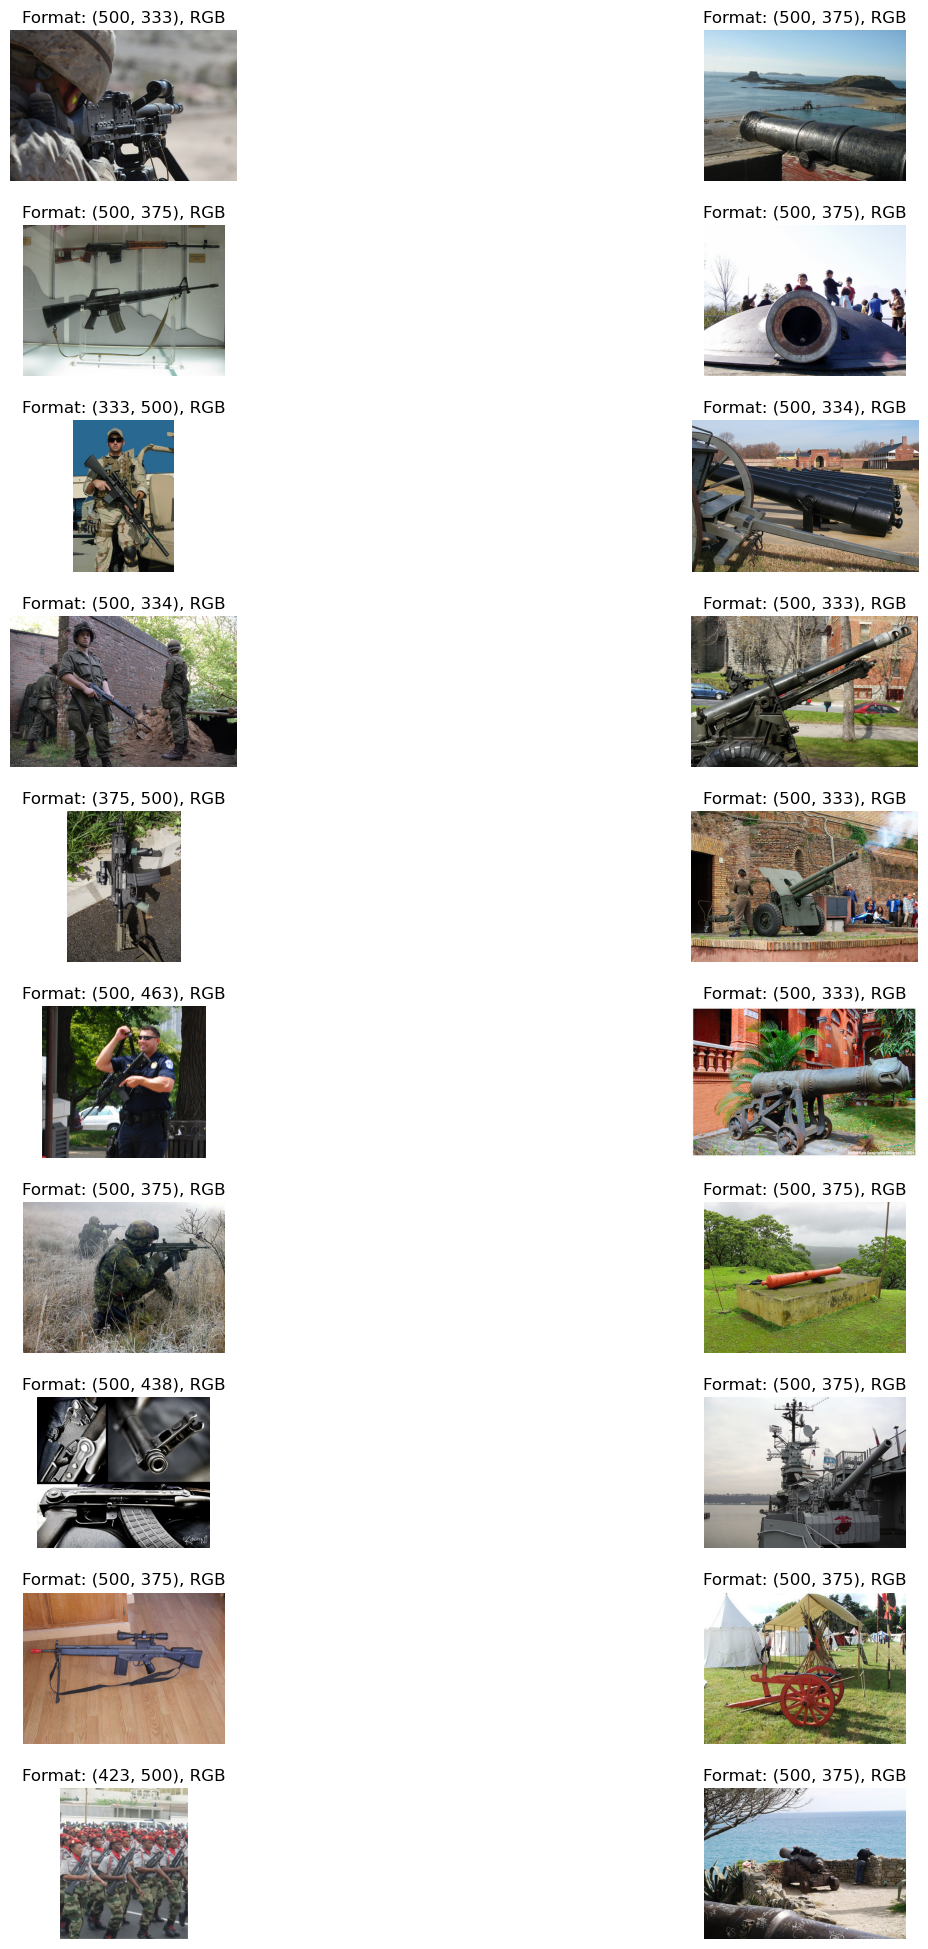

In [8]:
# Display loaded images

%matplotlib inline 

import matplotlib.pyplot as plt 

assault_rifle_wnid = 'n02749479'
cannon_wnid = 'n02950826'

figure = plt.figure(layout='constrained')
ax_list = [[i, i+1] for i in range(10)]
print(ax_list)
#ax_dict = figure.subplot_mosaic(ax_list)
#print(ax_dict)
fig, ax = plt.subplots(10,2)

fig_width = 35 / 2.54 
fig_height = 50 / 2.54 
fig.set_size_inches(fig_width, fig_height)
fig.tight_layout()

print(imagenet_x_small_sorted.keys())
id_images = []
for i in range(10):
    id_images.append(Image.open(imagenet_x_sorted[assault_rifle_wnid][i]._impath))
    #ax_dict[i*2].imshow(id_images[i])
    ax[i, 0].imshow(id_images[i])
    ax[i, 0].set_title(f'Format: {id_images[i].size}, {id_images[i].mode}')
    ax[i, 0].axis('off')

images_second_row = []
for i in range(10):
    images_second_row.append(Image.open(imagenet_x_sorted[cannon_wnid][i]._impath))
    ax[i, 1].imshow(images_second_row[i])
    ax[i, 1].set_title(f'Format: {images_second_row[i].size}, {images_second_row[i].mode}')
    ax[i, 1].axis('off')

# ood_images = [] 
# for i in range(10):
#     ood_images.append(Image.open(imagenet_r_sorted['Afghan Hound'][i]._impath))
#     #ax_dict[i*2+1].imshow(ood_images[i])
#     ax[i, 2].imshow(ood_images[i])
#     ax[i, 2].set_title(f'Format: {ood_images[i].size}, {ood_images[i].mode}')
#     ax[i, 2].axis('off')


In [8]:
# Load DINOv2 model 


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device}')

dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14.eval()
dinov2_vits14.to(device)

transform = transforms.Compose([transforms.Resize((154, 210)),
                                transforms.ToTensor()])


Device used: cuda


Using cache found in /home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main
/home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [9]:
# help functions for measuring semantic encoding distance 

def get_random_class() -> str:
    all_classes = list(imagenet_x_sorted.keys())
    n_classes = len(all_classes)
    next_int = random.randint(0, n_classes - 1)
    next_class = all_classes[next_int]

    return next_class

In [ ]:
with open('/home/afroehli/coding/pickle_data/imagenet_x_val_results.pkl', 'rb') as pickle_file:
    imagenet_x_val_results = pickle.load(pickle_file)

In [ ]:

# speed up computation 
preloaded_results = True
if not preloaded_results:
    imagenet_x_val_results = dict()

ood_id_random_combination = []
random_compare_set = dict()
random_set_size = 10 

random.seed(3)

for it, ood_id_pair in enumerate(class_splits): 

    ood_wnid, id_wnid = ood_id_pair 
    random_class_wnid = get_random_class()
    random_set = [get_random_class() for i in range(0, random_set_size)]

    ood_id_random_combination.append((ood_wnid, id_wnid, random_class_wnid))
    random_compare_set[(ood_wnid, id_wnid, random_class_wnid)] = copy.deepcopy(random_set)

    print(f'Iteration {it}. Next triple processed: {semantic_info.wnid_to_classname[ood_wnid]}',
          f', {semantic_info.wnid_to_classname[id_wnid]}, {semantic_info.wnid_to_classname[random_class_wnid]}.\n'
          f'Random-compare-set: {[semantic_info.wnid_to_classname[random_wnid] for random_wnid in random_set]}.')
    
    
    image_processed = 0
    
    wnid_set = [ood_wnid, id_wnid, random_class_wnid]
    wnid_set.extend(random_set)
    for wnid in wnid_set:

        covered_classes = list(imagenet_x_val_results.keys())
        
        if not wnid in covered_classes:
            for dassl_instance in imagenet_x_sorted[wnid]:

                pic_data = transform(Image.open(dassl_instance.impath).convert('RGB')).unsqueeze(0)
                pic_data_cuda = pic_data.to(device)

                model_out = dinov2_vits14(pic_data_cuda)
                try: 
                    imagenet_x_val_results[wnid].append(model_out.cpu().data.numpy()[0])
                except KeyError:
                    imagenet_x_val_results[wnid] = [model_out.cpu().data.numpy()[0]]

            image_processed = image_processed + len(imagenet_x_sorted[wnid])
        else:
            print(f'Class *{semantic_info.wnid_to_classname[wnid]}* is already covered.')

    print(f'Images processed in this iteration: {image_processed}')


Iteration 0. Next triple processed:  vulture ,  bald eagle,  poke bonnet.
Random-compare-set: [' Gordon Setter', ' sea slug', ' Toy Poodle', ' moped', ' volleyball', ' Appenzeller Sennenhund', ' mountain', ' Persian cat', ' Boston Terrier', ' little blue heron'].
Images processed in this iteration: 650
Iteration 1. Next triple processed:  Rottweiler ,  Boxer,  French Bulldog.
Random-compare-set: [' smooth newt', ' vacuum cleaner', ' schooner', ' chocolate syrup', ' cardboard box / carton', ' bittern bird', ' bikini', ' rock beauty fish', ' drilling rig', ' meatloaf'].
Images processed in this iteration: 650
Iteration 2. Next triple processed:  Boston Terrier ,  Yorkshire Terrier,  jellyfish.
Random-compare-set: [' weighing scale', ' hermit crab', ' coral reef', ' farm plow', ' ant', ' sports car', ' fly', ' baby bib', ' longhorn beetle', ' bee'].
Class * Boston Terrier* is already covered.
Images processed in this iteration: 600
Iteration 3. Next triple processed:  Chow Chow ,  Pomeran

In [ ]:
# dump calculated embedding values of selected class 

with open('/home/afroehli/coding/pickle_data/imagenet_x_val_results.pkl', 'wb') as pickle_file:
    pickle.dump(imagenet_x_val_results, pickle_file, pickle.HIGHEST_PROTOCOL)

with open('/home/afroehli/coding/pickle_data/ood_id_random_combination.pkl', 'wb') as pickle_file:
    pickle.dump(ood_id_random_combination, pickle_file, pickle.HIGHEST_PROTOCOL)

with open('/home/afroehli/coding/pickle_data/random_compare_set.pkl', 'wb') as pickle_file:
    pickle.dump(random_compare_set, pickle_file, pickle.HIGHEST_PROTOCOL)


In [ ]:
# check if dump was successful 

with open('/home/afroehli/coding/pickle_data/imagenet_x_val_results.pkl', 'rb') as pickle_file:
    imagenet_x_val_results = pickle.load(pickle_file)

with open('/home/afroehli/coding/pickle_data/ood_id_random_combination.pkl', 'rb') as pickle_file:
    ood_id_random_combination = pickle.load(pickle_file)

with open('/home/afroehli/coding/pickle_data/random_compare_set.pkl', 'rb') as pickle_file:
    random_compare_set = pickle.load(pickle_file)


In [13]:
# check test run output 

for it,  combination in enumerate(ood_id_random_combination): 
    
    ood_wnid, id_wnid, random_wnid = combination
    ood_name = semantic_info.wnid_to_classname[ood_wnid]
    id_name = semantic_info.wnid_to_classname[id_wnid]
    random_name = semantic_info.wnid_to_classname[random_wnid]

    print(f'Iteration {it}: {(ood_name, ood_wnid), (id_name, id_wnid), (random_name, random_wnid)}')
    ood_results = imagenet_x_val_results[ood_wnid]
    id_results = imagenet_x_val_results[id_wnid]
    random_results = imagenet_x_val_results[random_wnid]

    print(f'OOD-output size: {len(ood_results)}')
    print(f'ID-output size: {len(id_results)}')
    print(f'Random-output size: {len(random_results)}')

    print('\n\n')

Iteration 0: ((' vulture', 'n01616318'), (' bald eagle', 'n01614925'), (' poke bonnet', 'n02869837'))
OOD-output size: 50
ID-output size: 50
Random-output size: 50



Iteration 1: ((' Rottweiler', 'n02106550'), (' Boxer', 'n02108089'), (' French Bulldog', 'n02108915'))
OOD-output size: 50
ID-output size: 50
Random-output size: 50



Iteration 2: ((' Boston Terrier', 'n02096585'), (' Yorkshire Terrier', 'n02094433'), (' jellyfish', 'n01910747'))
OOD-output size: 50
ID-output size: 50
Random-output size: 50



Iteration 3: ((' Chow Chow', 'n02112137'), (' Pomeranian', 'n02112018'), (' stopwatch', 'n04328186'))
OOD-output size: 50
ID-output size: 50
Random-output size: 50



Iteration 4: ((' Whippet', 'n02091134'), (' Italian Greyhound', 'n02091032'), (' dough', 'n07860988'))
OOD-output size: 50
ID-output size: 50
Random-output size: 50



Iteration 5: ((' Shih Tzu', 'n02086240'), (' Chihuahua', 'n02085620'), (' electric fan', 'n03271574'))
OOD-output size: 50
ID-output size: 50
Random-ou

In [21]:
# calculate means of embeddings 

statistics_dict = dict()

# def class_std_area(class_1, class_2):
#     return vect_dim_std_area(class_1, class_2)

def dim_std_area(std_1, std_2):
    if std_1 < std_2:
        return 2 * std_2 
    else:
        return 2 * std_1 

vect_dim_std_area = np.vectorize(dim_std_area)
# vect_class_std_area = np.vectorize(class_std_area)

# def max_min_on_class(class_mean, class_std):
#     return vect_max_min_on_dim(class_mean, class_std)

def max_min_on_dim(dim_mean, dim_std):
    return (dim_mean - dim_std, dim_mean + dim_std)

vect_max_min_on_dim = np.vectorize(max_min_on_dim)
# vect_max_min_on_class = np.vectorize(max_min_on_class)

# def calc_union_area(max_min_class_1, max_min_class_2):
#      return vect_calc_union_area_dim(max_min_class_1, max_min_class_2)
    
def calc_union_area_dim(min_dim_class_1, max_dim_class_1, min_dim_class_2, max_dim_class_2):
    min_1 = min_dim_class_1 
    max_1 = max_dim_class_1 

    min_2 = min_dim_class_2
    max_2 = max_dim_class_2
    
    # no intersection 
    if max_1 <= min_2 or max_2 <= min_1:
        return 0 
    # left overlapping of 1 / right overlapping of 2
    elif min_1 <= min_2 and max_1 <= max_2:
        return max_1 - min_2
    # left overlapping of 2 / right overlapping of 1
    elif min_2 <= min_1 and max_2 <= max_1:
        return max_2 - min_1 
    # 1 within 2 
    elif max_1 <= max_2:
        return max_1 - min_1 
    # 2 within 1
    else:
        return max_2 - min_2
    
vect_calc_union_area_dim = np.vectorize(calc_union_area_dim)
# vect_calc_union_area = np.vectorize(calc_union_area)


for class_combination in ood_id_random_combination: 

    ood_wnid, id_wnid, random_wnid = class_combination 

    ood_results = np.array(imagenet_x_val_results[ood_wnid])
    id_results = np.array(imagenet_x_val_results[id_wnid])
    random_results = np.array(imagenet_x_val_results[random_wnid])
    # shape = 10 x 50 x 384  (N pictures)
    random_compare_results = np.array([imagenet_x_val_results[comp_wnid] for comp_wnid in random_compare_set[class_combination]])

    ood_mean = np.mean(ood_results, axis=0)
    id_mean = np.mean(id_results, axis=0)
    random_mean = np.mean(random_results, axis=0)

    # shape = 10 x 384
    random_compare_mean_1 = np.mean(random_compare_results, axis=1)
    # shape = 384
    random_compare_mean = np.mean(random_compare_mean_1, axis=0)
    
    ood_std = np.std(ood_results, axis=0)
    id_std = np.std(id_results, axis=0)
    random_std = np.std(random_results, axis=0)
    
    diff_id_ood = np.abs(id_mean - ood_mean)
    diff_random_ood = np.abs(random_mean - ood_mean)
    diff_random_comp_ood = np.abs(random_compare_mean - ood_mean)

    statistics_dict[class_combination] = dict()
    
    true_false_list = (diff_id_ood < diff_random_ood).tolist()
    id_is_nearer = true_false_list.count(True)
    statistics_dict[class_combination]['id_random'] = id_is_nearer

    true_false_list = (diff_id_ood < ood_std).tolist()
    id_within_std = true_false_list.count(True)
    statistics_dict[class_combination]['id_std'] = id_within_std

    true_false_list = (diff_random_ood < ood_std).tolist()
    random_within_std = true_false_list.count(True)
    statistics_dict[class_combination]['random_std'] = random_within_std

    true_false_list = (diff_id_ood < diff_random_comp_ood).tolist()
    id_is_nearer_comp = true_false_list.count(True)
    statistics_dict[class_combination]['id_random_comp'] = id_is_nearer_comp 

    true_false_list = (diff_random_comp_ood < ood_std).tolist()
    random_comp_within_std = true_false_list.count(True)
    statistics_dict[class_combination]['random_comp_std'] = random_comp_within_std

    # calculate coverage between stds of ood and id per dim 
    
    # shape (384)
    ood_id_std_area = vect_dim_std_area(ood_std, id_std)
    ood_random_std_area = vect_dim_std_area(ood_std, random_std)

    # for id, ood, random: for each class: for each dim: (min = mean - std, max = mean + std)
    max_min_per_dim_id = vect_max_min_on_dim(id_mean, id_std) 
    max_min_per_dim_ood = vect_max_min_on_dim(ood_mean, ood_std)
    max_min_per_dim_random = vect_max_min_on_dim(random_mean, random_std)

    union_area_between_ood_id = vect_calc_union_area_dim(max_min_per_dim_id[0], max_min_per_dim_id[1], 
                                                         max_min_per_dim_ood[0], max_min_per_dim_ood[1])
    union_area_between_ood_random = vect_calc_union_area_dim(max_min_per_dim_random[0], max_min_per_dim_random[1], 
                                                             max_min_per_dim_ood[0], max_min_per_dim_ood[1])
    covered_area_ood_id = union_area_between_ood_id / ood_id_std_area
    covered_area_ood_random = union_area_between_ood_random / ood_random_std_area

    statistics_dict[class_combination]['id_std_covered'] = covered_area_ood_id 
    statistics_dict[class_combination]['random_std_covered'] = covered_area_ood_random


In [22]:
# store statistics on ood-id-random combinations

with open('/home/afroehli/coding/pickle_data/ood_id_random_statistics.pkl', 'wb') as pickle_file:
    pickle.dump(statistics_dict, pickle_file, pickle.HIGHEST_PROTOCOL)


In [23]:
# load dumped statistics information on ood-id-random combination

with open('/home/afroehli/coding/pickle_data/ood_id_random_statistics.pkl', 'rb') as pickle_file:
    statistics_ood_id_random = pickle.load(pickle_file)

In [52]:
# output of statistic information on ood-id-random combination 

# Heading 
print(f'\tCombination\t\t|\tID-RANDOM\t|\tID-STD\t\t|\tRAN-STD\t')
print(f'\t-----------\t\t|\t---------\t|\t------\t\t|\t-------\t')
print('')

for combination in statistics_ood_id_random: 

    ood_wnid, id_wnid, random_wnid = combination 
    ood_name, id_name, random_name = [semantic_info.wnid_to_classname[wnid] for wnid in combination]

    id_nearer = statistics_ood_id_random[combination]['id_random']
    id_std = statistics_ood_id_random[combination]['id_std']
    ran_std = statistics_ood_id_random[combination]['random_std']

    id_nearer_rel = (id_nearer / 384) * 100 
    id_std_rel = (id_std / 384) * 100 
    ran_std_rel = (ran_std / 384) * 100 

    print(f'\t{ood_name}')
    print(f'\t{id_name},\t\t|\t{id_nearer_rel:.2f}\t|\t{id_std_rel:.2f}\t\t|\t{ran_std_rel:.2f}\t'.expandtabs(6))
    print(f'\t{random_name}')

    print('')

	Combination		|	ID-RANDOM	|	ID-STD		|	RAN-STD	
	-----------		|	---------	|	------		|	-------	

	 vulture
       bald eagle,            |     62.50 |     88.54       |     73.96 
	 poke bonnet

	 Rottweiler
       Boxer,           |     34.11 |     58.59       |     82.55 
	 Gordon Setter

	 Boston Terrier
       Yorkshire Terrier,           |     53.65 |     58.33       |     51.04 
	 sea slug

	 Chow Chow
       Pomeranian,            |     60.94 |     86.72       |     68.23 
	 Toy Poodle

	 Whippet
       Italian Greyhound,           |     72.66 |     96.35       |     62.76 
	 moped

	 Shih Tzu
       Chihuahua,       |     59.38 |     69.79       |     64.58 
	 volleyball

	 king penguin
       pelican,         |     53.39 |     54.17       |     46.35 
	 Appenzeller Sennenhund

	 gorilla
       orangutan,       |     69.53 |     91.15       |     66.67 
	 mountain

	 junco
       goldfinch,       |     58.59 |     64.32       |     58.07 
	 Persian cat

	 assault rifle
       can

                                          Comb  Rel        Cov
0      ('n01616318', 'n01614925', 'n02869837')   ID  86.419083
1      ('n01616318', 'n01614925', 'n02869837')   ID  52.364666
2      ('n01616318', 'n01614925', 'n02869837')   ID  59.112949
3      ('n01616318', 'n01614925', 'n02869837')   ID  49.337219
4      ('n01616318', 'n01614925', 'n02869837')   ID  83.553246
...                                        ...  ...        ...
46075  ('n01882714', 'n02325366', 'n02930766')  50%  50.000000
46076  ('n01882714', 'n02325366', 'n02930766')  50%  50.000000
46077  ('n01882714', 'n02325366', 'n02930766')  50%  50.000000
46078  ('n01882714', 'n02325366', 'n02930766')  50%  50.000000
46079  ('n01882714', 'n02325366', 'n02930766')  50%  50.000000

[46080 rows x 3 columns]
    DiffIDRandomFromOOD  50%
0             62.500000   50
1             53.645833   50
2             54.687500   50
3             65.364583   50
4             69.791667   50
5             58.333333   50
6             5

/tmp/ipykernel_403358/166053674.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  std_coverage_df = pd.concat([std_coverage_df, new_rows_df], ignore_index=True)


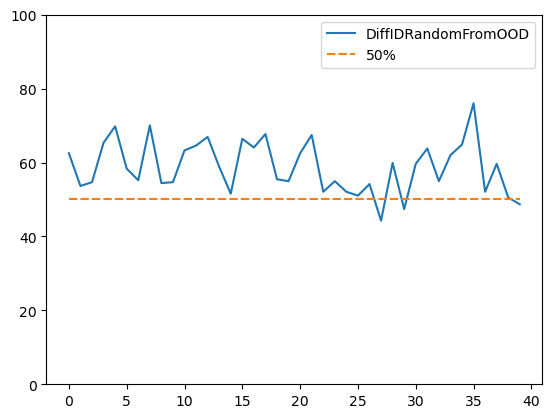

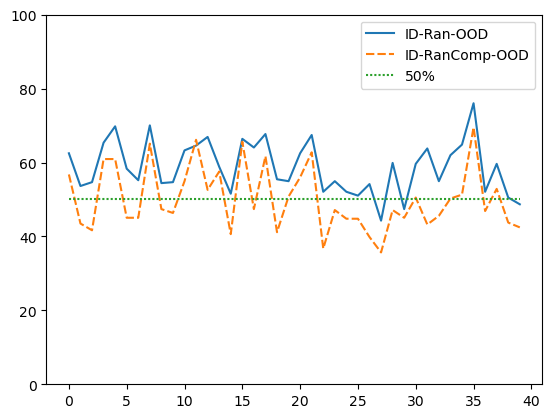

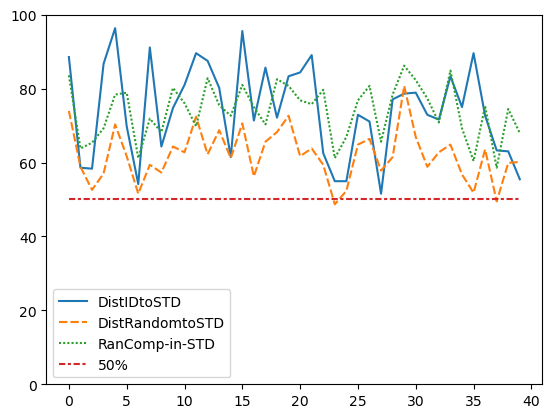

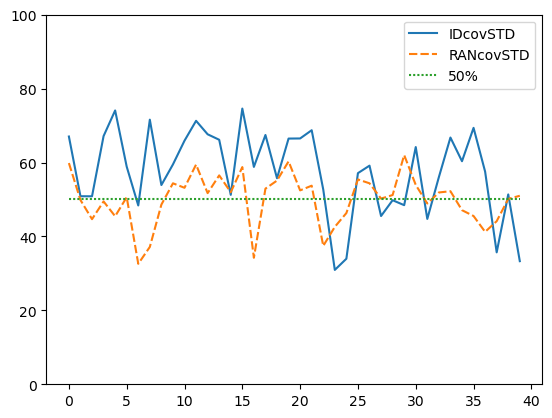

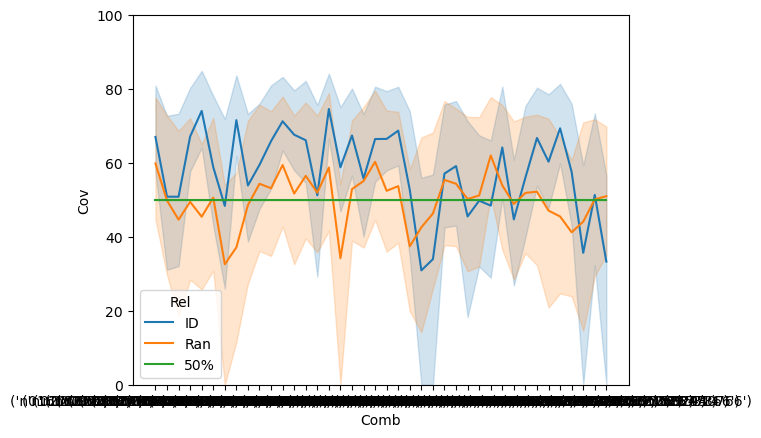

In [24]:
# visualize statistics on ood-id-random in single graph 

all_combinations = list(statistics_ood_id_random.keys())

all_id_random_rel = [(statistics_ood_id_random[combination]['id_random'] / 384) * 100 for combination in all_combinations]
all_id_random_comp_rel = [(statistics_ood_id_random[combination]['id_random_comp'] / 384) * 100 for combination in  all_combinations]
all_id_std_rel = [(statistics_ood_id_random[combination]['id_std'] / 384) * 100 for combination in  all_combinations]
all_random_std_rel = [(statistics_ood_id_random[combination]['random_std'] / 384) * 100 for combination in  all_combinations]
all_random_comp_std_rel = [(statistics_ood_id_random[combination]['random_comp_std'] / 384) * 100 for combination in  all_combinations]

std_coverage_df = pd.DataFrame(columns=['Comb', 'Rel', 'Cov'])

fifty_line = [50 for i in range(0, 384)]
fifty_line_df = pd.DataFrame(data=fifty_line, columns=["Cov"])
fifty_line_df['Rel'] = '50%'

for combination in list(statistics_ood_id_random.keys()):
    new_rows_id_df = pd.DataFrame(data=(statistics_ood_id_random[combination]['id_std_covered'] * 100), columns=["Cov"])
    new_rows_id_df['Rel'] = 'ID'
    new_rows_random_df = pd.DataFrame(data=(statistics_ood_id_random[combination]['random_std_covered'] * 100), columns=["Cov"])
    new_rows_random_df['Rel'] = 'Ran'
    
    new_rows_df = pd.concat([new_rows_id_df, new_rows_random_df, fifty_line_df], axis=0)
    new_rows_df['Comb'] = str(combination)
    
    std_coverage_df = pd.concat([std_coverage_df, new_rows_df], ignore_index=True)
    # std_coverage_df = pd.concat(std_coverage_df, new_rows_random_df, ignore_indexes=True)

std_coverage_id_ood = [np.mean(statistics_ood_id_random[combination]['id_std_covered']) * 100 for combination in all_combinations]
std_coverage_random_ood = [np.mean(statistics_ood_id_random[combination]['random_std_covered']) * 100 for combination in all_combinations]
line_at_fifty = [50 for i in range(0, len(all_combinations))]

all_id_random_df = pd.DataFrame(data=list(zip(all_id_random_rel, line_at_fifty)), 
                                columns=['DiffIDRandomFromOOD', '50%'])

distance_to_std_df = pd.DataFrame(data=list(zip(all_id_std_rel, all_random_std_rel, all_random_comp_std_rel, line_at_fifty)),
                                columns=['DistIDtoSTD', 'DistRandomtoSTD', 'RanComp-in-STD', '50%'])

covered_std_of_ood_df = pd.DataFrame(data=list(zip(std_coverage_id_ood, std_coverage_random_ood, line_at_fifty)),
                                  columns=['IDcovSTD', 'RANcovSTD', '50%'])

id_random_comp_df = pd.DataFrame(data=list(zip(all_id_random_rel, all_id_random_comp_rel, line_at_fifty)),
                                 columns=['ID-Ran-OOD', 'ID-RanComp-OOD', '50%'])

print(std_coverage_df)
print(all_id_random_df)
print(covered_std_of_ood_df)
plt.ylim((0,100))
sns.lineplot(data=all_id_random_df)
plt.show()
plt.ylim((0,100))
sns.lineplot(data=id_random_comp_df)
plt.show()
plt.ylim((0,100))
sns.lineplot(data=distance_to_std_df)
plt.show()
plt.ylim((0, 100))
sns.lineplot(data=covered_std_of_ood_df)
plt.show()

plt.ylim((0, 100))
sns.lineplot(data=std_coverage_df, x='Comb', y='Cov', hue='Rel', markers=True, errorbar=('pi', 50))
plt.show()

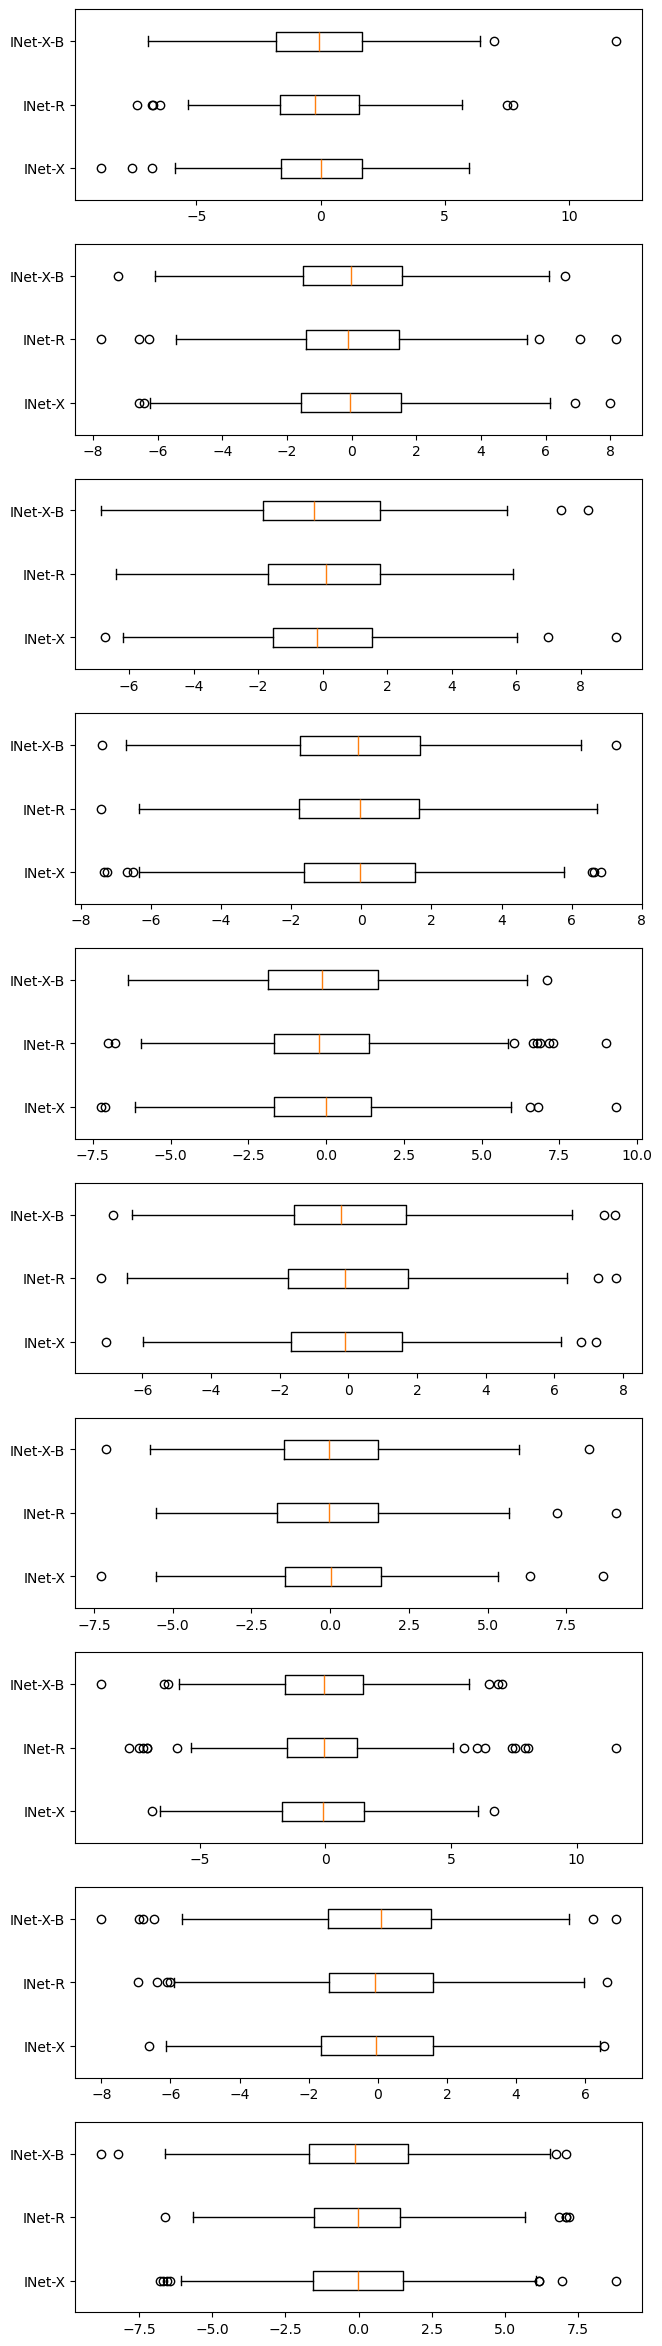

In [ ]:
# Visualize model output 

first_tensor = model_results['COVARIATE_ID'][0][1].cpu().detach().numpy()
sec_tensor = model_results['COVARIATE_ID'][1][1].cpu().detach().numpy()

fig, ax = plt.subplots(10, 1)
fig.set_figheight(60 / 2.54)
fig.tight_layout()

for i in range(10):
    ax[i].boxplot([model_results['COVARIATE_ID'][i][1].cpu().detach().numpy()[0], 
                   model_results['COVARIATE_OOD'][i][1].cpu().detach().numpy()[0],
                   model_results['COVARIATE_ID_BLOODHOUND'][i][1].cpu().detach().numpy()[0]],
                   tick_labels=['INet-X', 'INet-R', 'INet-X-B'], vert=False)

Joined:            0         1         2         3         4         5         6  \
0   4.176703 -2.478232 -2.496681 -4.860718  1.366178  1.461819 -0.242504   
1   0.538190 -1.205142  0.843365 -0.129299 -0.903159 -1.010873  0.287366   
2   2.145056 -1.102350 -1.583883 -0.713591 -1.129986 -1.268015  2.697985   
3   0.931107  0.812459  1.914902  2.180068 -0.020620 -0.349690  2.520671   
4   2.494304 -0.339870  2.575741 -3.399211 -3.138809 -0.859915 -0.384808   
5  -1.575824 -1.037287 -1.526749 -2.738299 -2.394892 -0.732795 -3.226099   
6   4.772925  0.386362  5.189932  1.982849 -1.380416 -1.424465 -2.453427   
7  -0.078431 -1.046944 -3.541739 -3.164675  0.443307  1.367367  0.358067   
8   0.935511 -1.576078 -0.729626 -4.625991  1.439337 -1.544890  2.036790   
9   0.647960 -1.676785 -1.501124 -2.630703 -2.524951 -1.050616 -2.074192   
10  1.838027 -1.637840  0.370819 -2.594353 -1.442883 -2.723868 -0.625369   
11 -1.444590 -1.699270 -1.379862 -3.292356 -3.139307 -0.700266  0.637664   
12 -

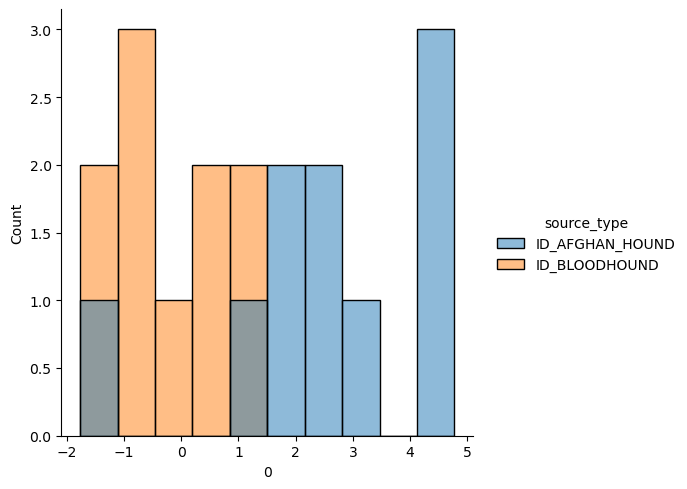

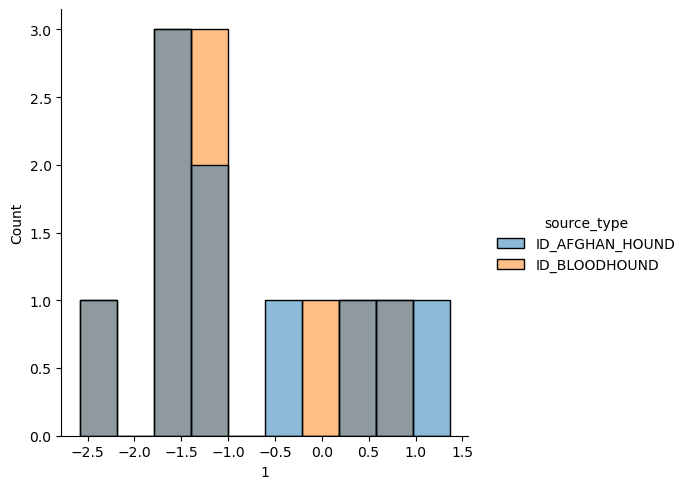

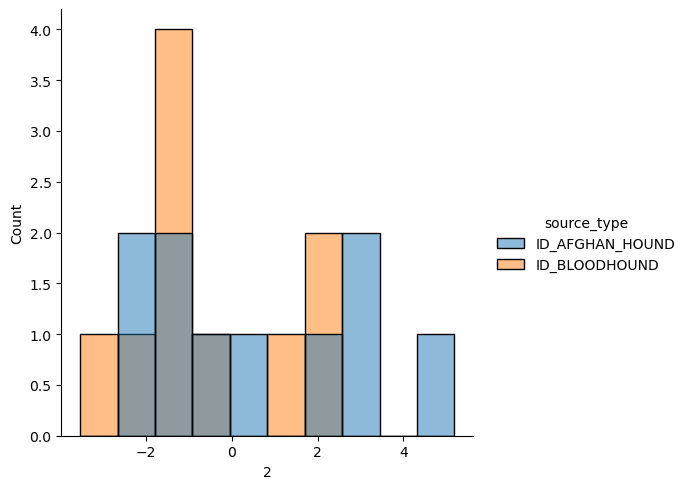

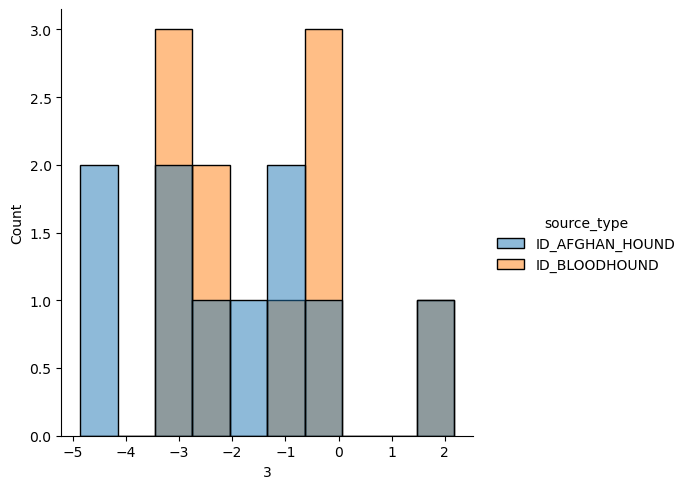

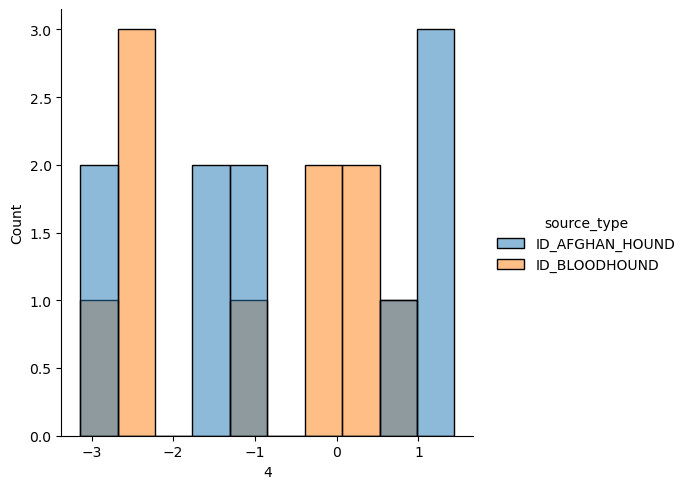

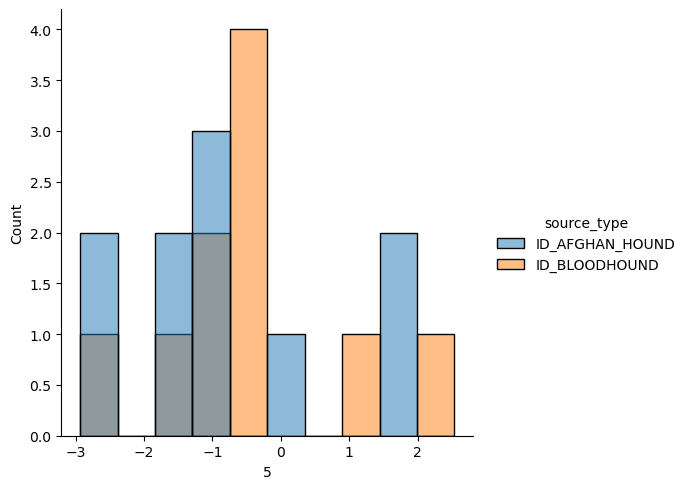

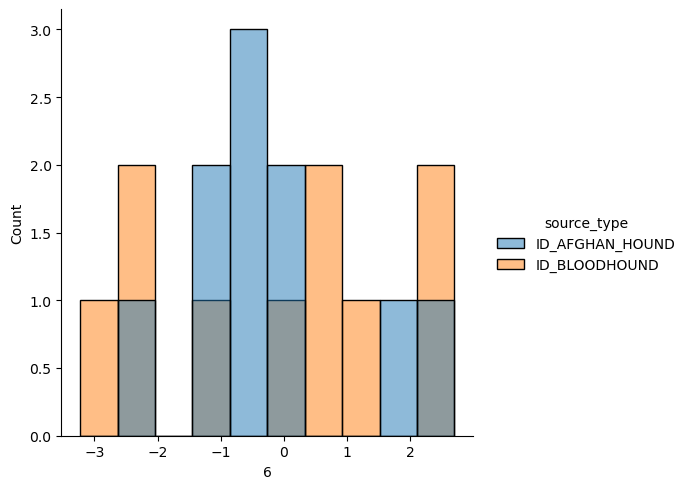

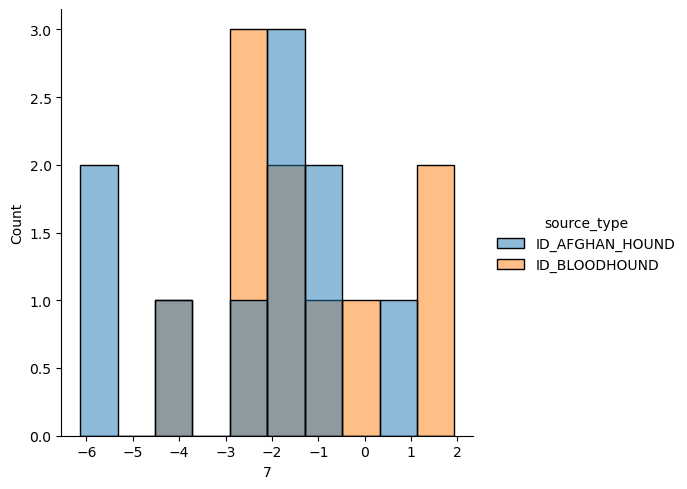

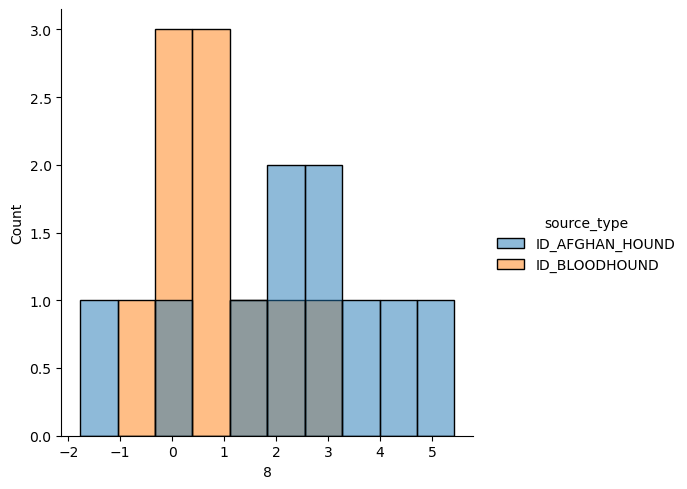

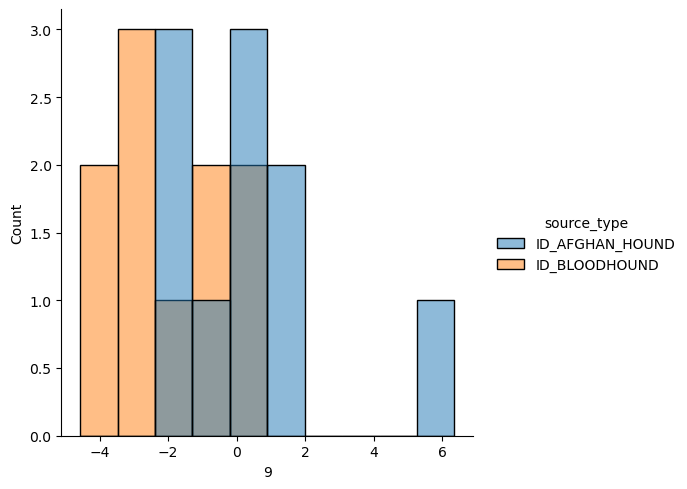

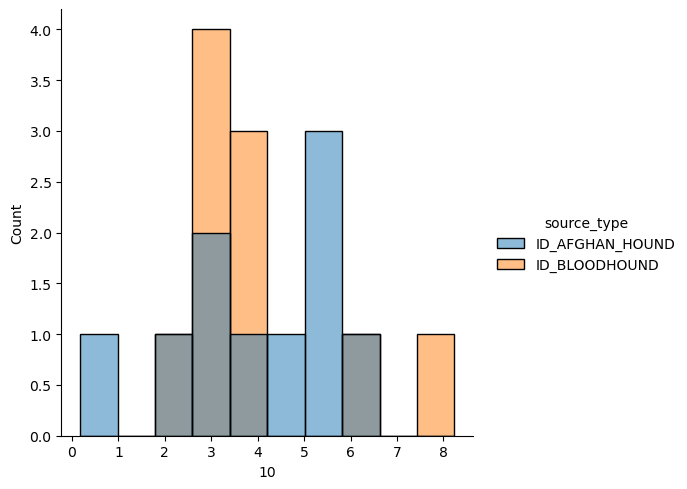

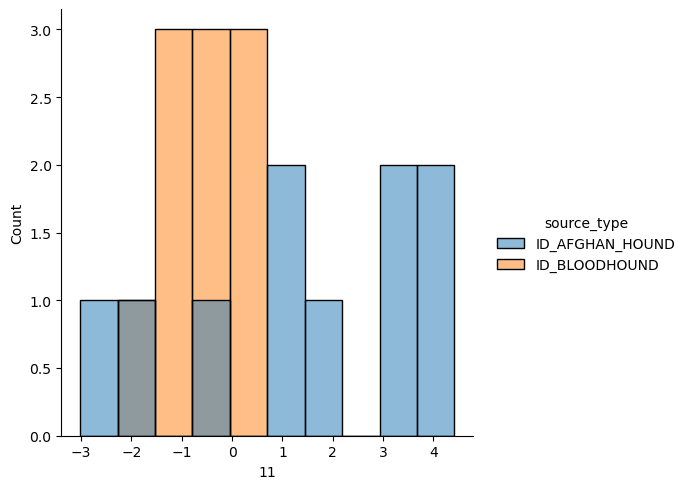

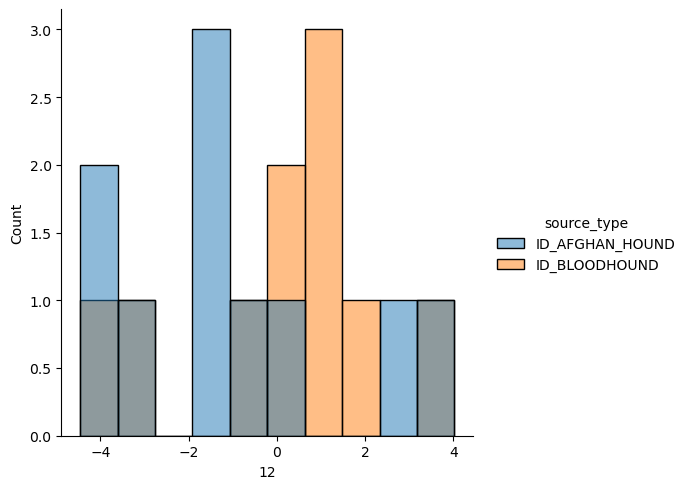

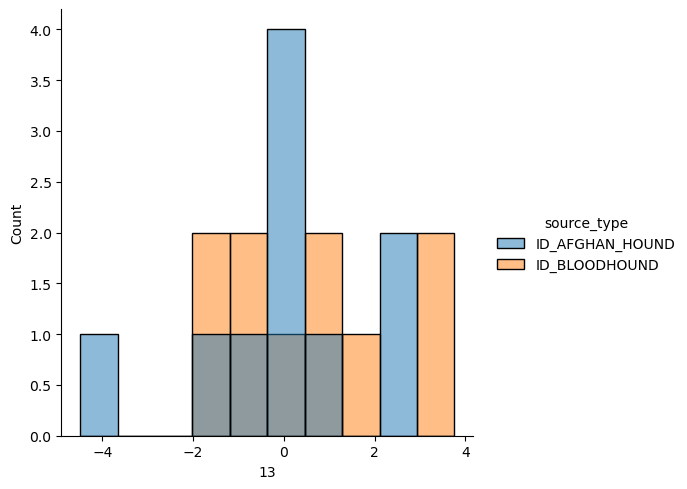

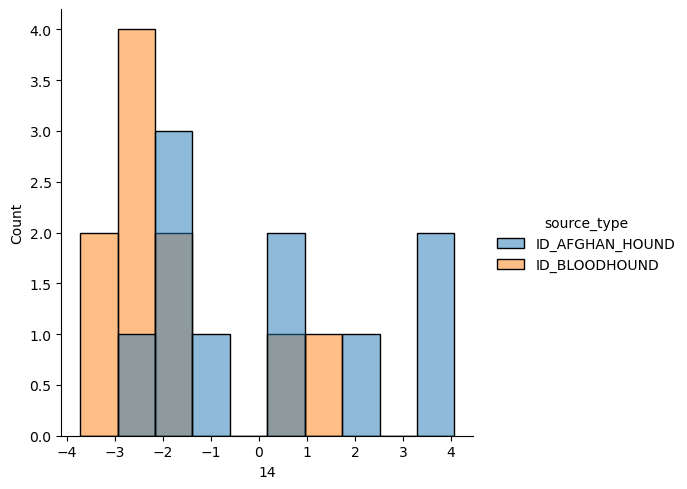

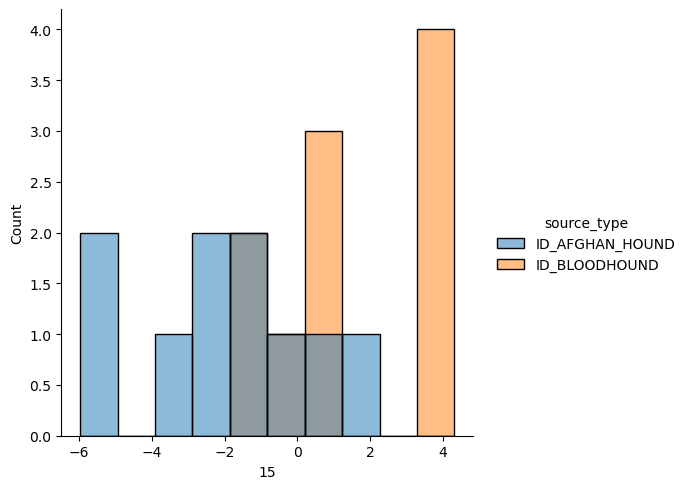

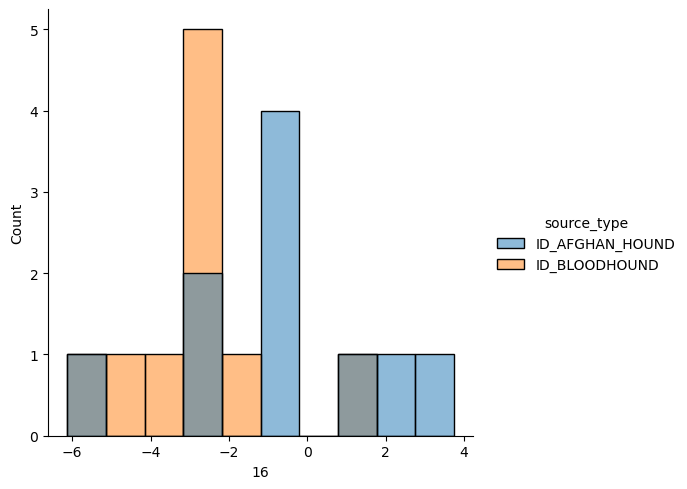

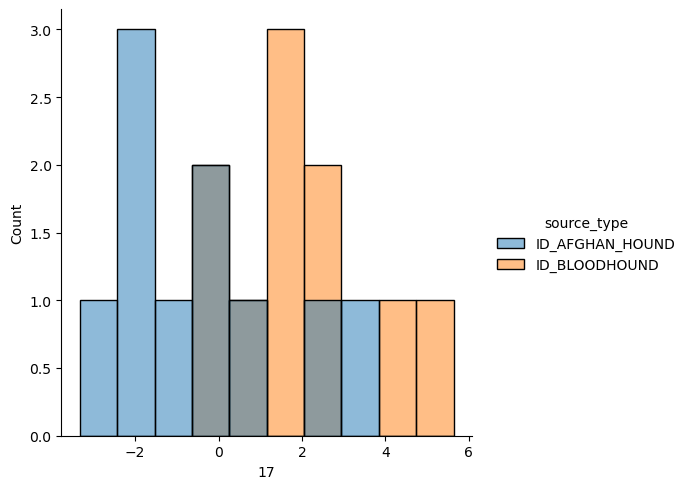

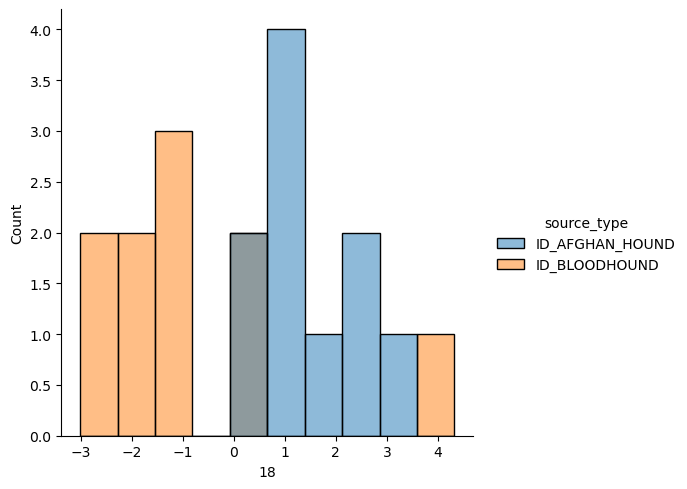

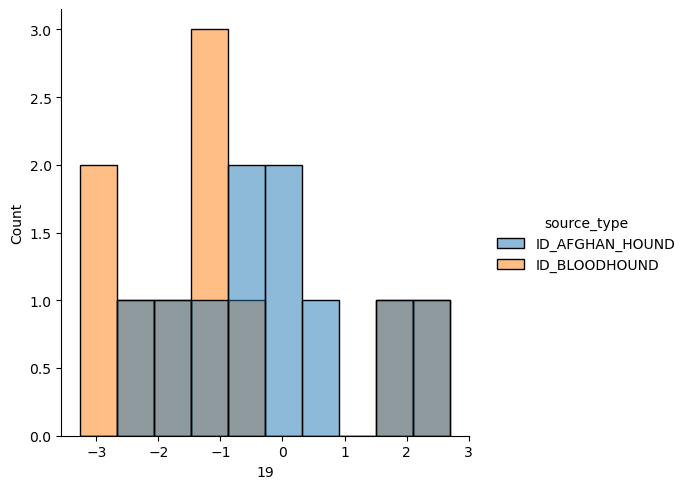

In [ ]:
# create pd-DataFrame for each model output

collection_pd_array = []

for i in range(10):
    pd_afghan_hound = pd.DataFrame(model_results['COVARIATE_ID'][i][1].cpu().detach().numpy())
    pd_afghan_hound['source_type'] = 'ID_AFGHAN_HOUND'
    collection_pd_array.append(pd_afghan_hound)

    pd_bloodhound = pd.DataFrame(model_results['COVARIATE_ID_BLOODHOUND'][i][1].cpu().detach().numpy())
    pd_bloodhound['source_type'] = 'ID_BLOODHOUND'
    collection_pd_array.append(pd_bloodhound)


joined_pd = pd.concat(collection_pd_array, ignore_index=True)
print(f'Joined: {joined_pd}')

print(joined_pd[[0, 'source_type']])

for embedding in range(20):
    sns.displot(joined_pd[[embedding, 'source_type']], x=joined_pd[embedding], hue='source_type', bins=10)